In [1]:
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices

# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.10},
    'R1': {'usd price': 2, 'weight': 0.20},
    'R2': {'usd price': 2/3, 'weight': 0.60},
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            lrna_fee=0.03,
            asset_fee=0.03
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={tkn: 10000000000 for tkn in list(assets.keys()) + ['LRNA']},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_attempts=1
            )
        )
    },
    evolve_function=fluctuate_prices(volatility={'R1': 1, 'R2': 1}, trend={'R1': 1, 'R2': 1}),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
)

time_steps = 5000
events = run.run(initial_state, time_steps=time_steps)

# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Starting simulation...
Execution time: 22.186 seconds.


<AxesSubplot:title={'center':'asset price: R2 '}>

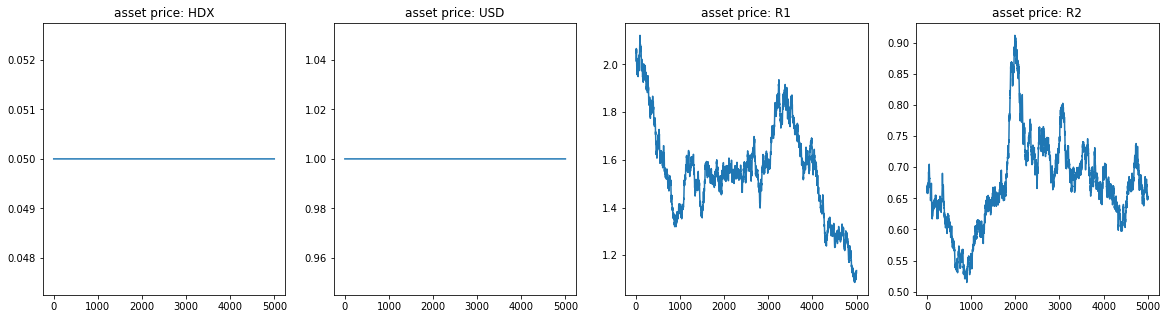

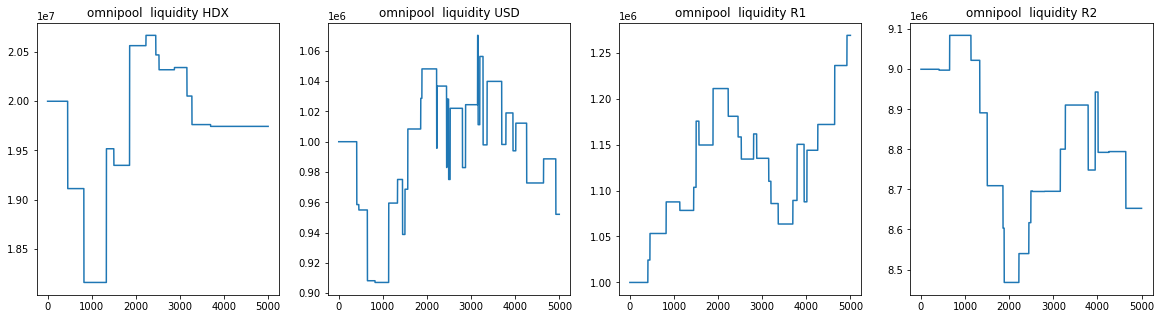

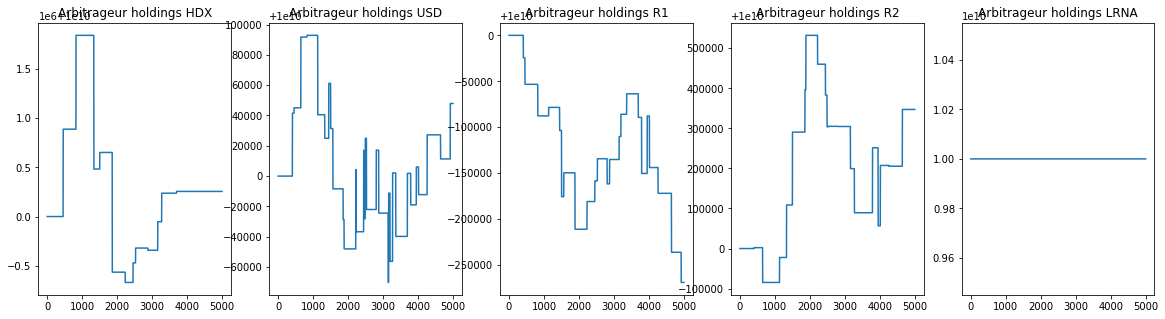

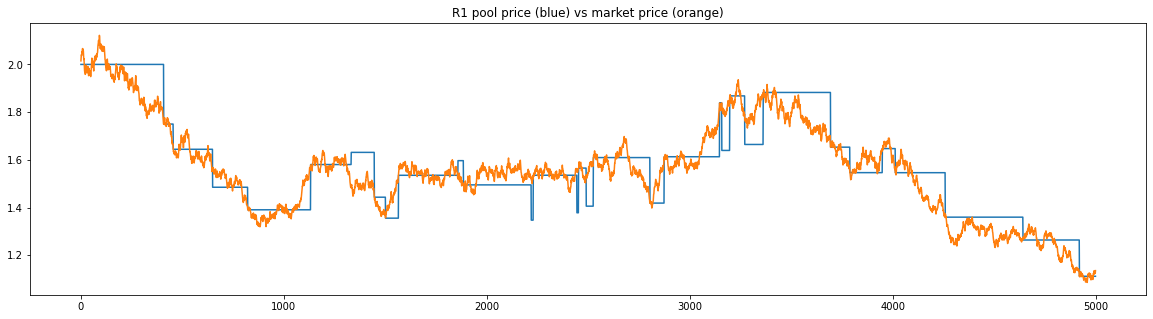

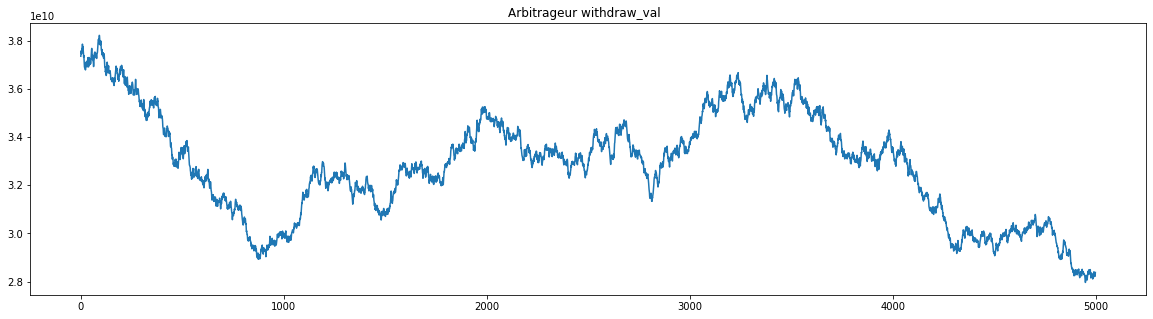

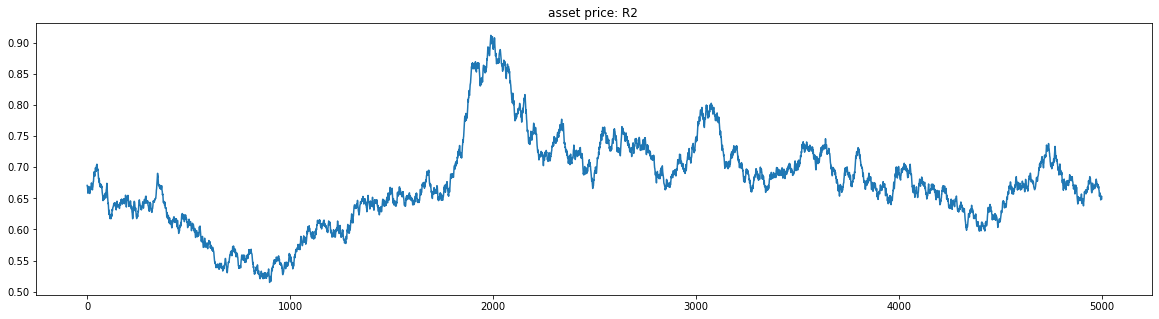

In [2]:
pu.plot(events, asset='all')
pu.plot(events, pool='omnipool', prop='liquidity')
lrna_price_in_usd = [event['state'].pools['omnipool'].liquidity['USD'] / event['state'].pools['omnipool'].lrna['USD'] for event in events]
R1_pool_price_usd = pu.get_datastream(events, pool='omnipool', prop='usd_price', key='R1')
# [event['state'].pools['omnipool'].lrna['R1'] * lrna_price_in_usd[i] / event['state'].pools['omnipool'].liquidity['R1'] for i, event in enumerate(events)]
pu.plot(events, agent='Arbitrageur', prop='holdings')
plt.figure(figsize=(20, 5))
plt.plot(range(time_steps), R1_pool_price_usd)
plt.plot(range(time_steps), pu.get_datastream(events, asset='R1'))
plt.title('R1 pool price (blue) vs market price (orange)')
pu.plot(events, agent='Arbitrageur', prop='withdraw_val')
pu.plot(events, asset='R2')

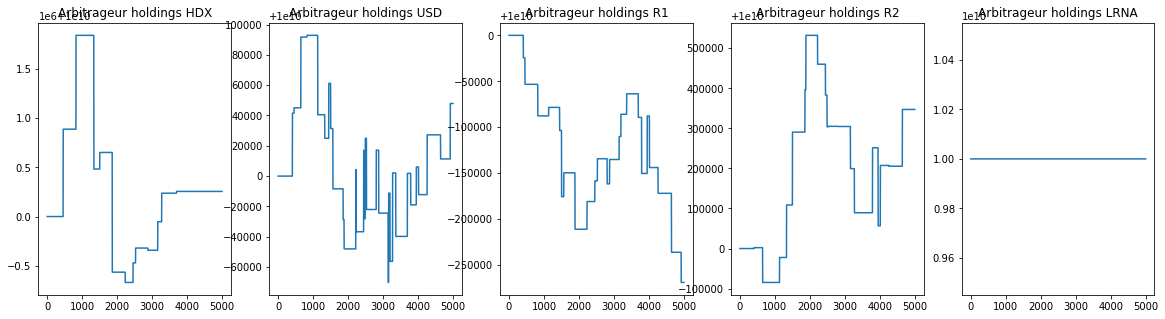

In [3]:
pu.plot(events, agent='Arbitrageur', prop='holdings')

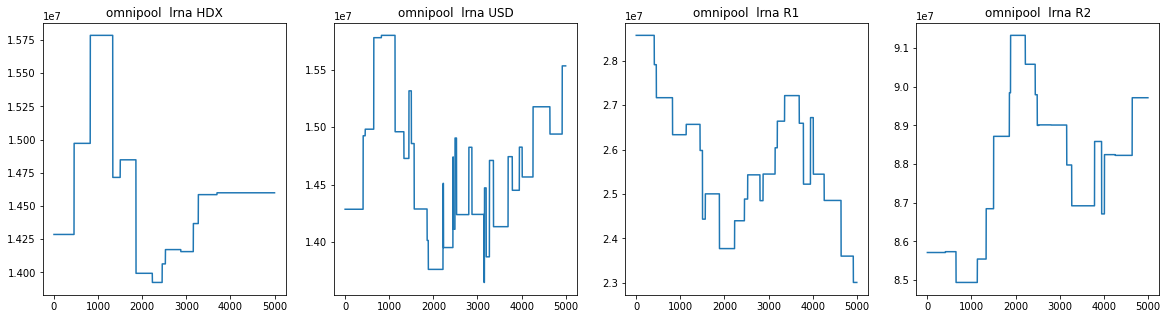

In [4]:
pu.plot(events, pool='omnipool', prop='lrna')

In [9]:
random.seed(42)

precision_arb_state = initial_state.copy()
precision_arb_state.agents['Arbitrageur'].trade_strategy=omnipool_arbitrage(
    pool_id='omnipool',
    arb_attempts=3
)

events2 = run.run(precision_arb_state, time_steps=time_steps)

Starting simulation...
Execution time: 37.677 seconds.


Text(0.5, 1.0, 'R1 pool price (blue) vs market price (orange)')

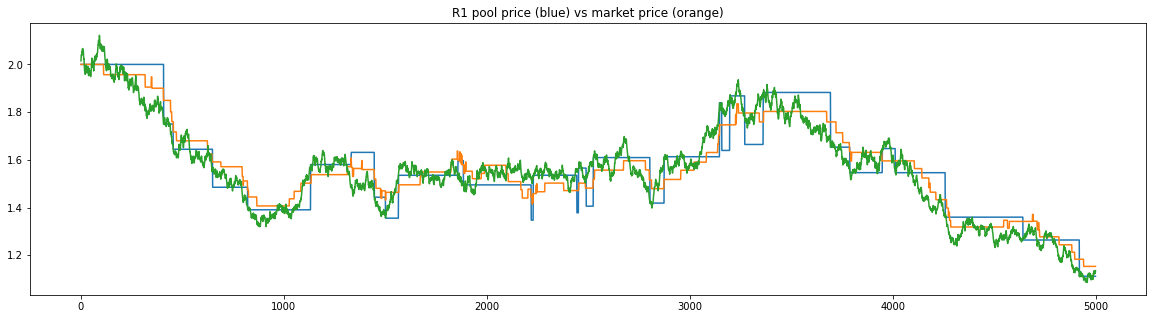

In [10]:
R1_pool_price_usd_round_2 = pu.get_datastream(events2, pool='omnipool', prop='usd_price', key='R1')
# [event['state'].pools['omnipool'].lrna['R1'] * lrna_price_in_usd[i] / event['state'].pools['omnipool'].liquidity['R1'] for i, event in enumerate(events)]
plt.figure(figsize=(20, 5))
plt.plot(range(time_steps), R1_pool_price_usd)
plt.plot(range(time_steps), R1_pool_price_usd_round_2)
plt.plot(range(time_steps), pu.get_datastream(events2, asset='R1'))
plt.title('R1 pool price (blue) vs market price (orange)')